## Batch correction tools (BBKNN, Scanorama)

This Jupyter notebook contains:

1) Load trial datasets (in this example, 3 10X datasets)

2) some QC of the data 

3) BBKNN

4) Scanorama

In [1]:
import numpy as np
import pandas as pd
import scanpy.api as sc
import anndata

import bbknn
import scanorama

import os
import scipy
from scipy import sparse
import sys

sc.settings.verbosity = 3 
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
sc.logging.print_versions()

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


scanpy==1.4 anndata==0.6.18 numpy==1.16.1 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.20.2 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


/opt/conda/lib/python3.6/site-packages/scanorama-1.0-py3.6.egg/scanorama/utils.py:5: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/opt/conda/lib/pyth

### 1) Load datasets

The datasets used as trial are 3 10X datasets:
- 1k PBMCs from a Healthy Donor (v2 chemistry)
- 1k PBMCs from a Healthy Donor (v3 chemistry)
- 3k PBMCs from a Healthy Donor (v1 chemistry)--> No .h5 available file for this dataset, we load its matrix.mtx, genes.tsv and barcodes.tsv files.

Reading the files (some issues):
- sc.read_10x_h5 
- sc.read_10x_mtx works well if provided a path to a directory with: matrix.mtx, barcodes.tsv, genes.tsv. 
    Note that genes has to be provided as genes.tsv. Any other name won't work.
- sc.read_h5ad gives empty AnnData objects if given a .h5 file

In [4]:
#load datasets (as h5)
A_data = sc.read_10x_h5("../data/pbmc_1k_v2_filtered_feature_bc_matrix.h5")
B_data = sc.read_10x_h5("../data/pbmc_1k_v3_filtered_feature_bc_matrix.h5")
#no h5 available for this dataset
C_data = sc.read_10x_mtx("../data/pbmc3k_filtered_gene_bc_matrices/hg19/")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


reading ../data/pbmc_1k_v2_filtered_feature_bc_matrix.h5 (0:00:00.12)
reading ../data/pbmc_1k_v3_filtered_feature_bc_matrix.h5 

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(0:00:00.16)
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


### 2) QC

2.1) Some pre-filtering:
- Remove those cells with less than 200 genes expressed
- Remove those genes expressed in less than 3 cells
- Calculate the percentage of mitochondrial genes
- Create n_counts per cell variable

In [5]:
#some QC
datasets =[A_data, B_data, C_data]
for dataset in datasets:
    dataset.var_names_make_unique()
    #filter cells and genes
    sc.pp.filter_cells(dataset, min_genes=200)
    sc.pp.filter_genes(dataset, min_cells=3) 
    
    mito_genes = [name for name in dataset.var_names if name.startswith('MT-')]
    dataset.obs['percent_mito'] = np.sum(dataset[:, mito_genes].X, axis=1).A1 / np.sum(dataset.X, axis=1).A1
    dataset.obs['n_counts'] = dataset.X.sum(axis=1).A1

filtered out 1 cells that have less than 200 genes expressed
filtered out 20468 genes that are detected in less than 3 cells
filtered out 46 cells that have less than 200 genes expressed
filtered out 18292 genes that are detected in less than 3 cells
filtered out 19024 genes that are detected in less than 3 cells


2.2) Some QC plots

... storing 'feature_types' as categorical
... storing 'genome' as categorical


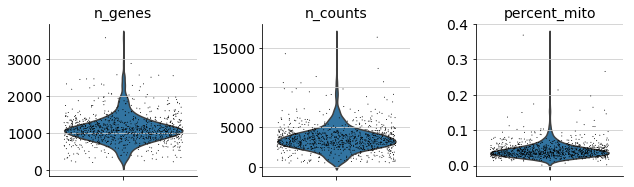

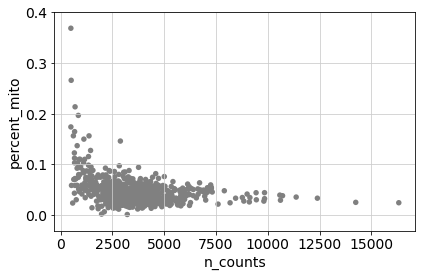

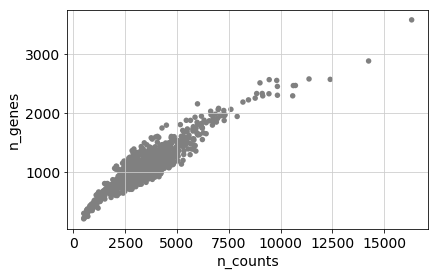

... storing 'feature_types' as categorical
... storing 'genome' as categorical


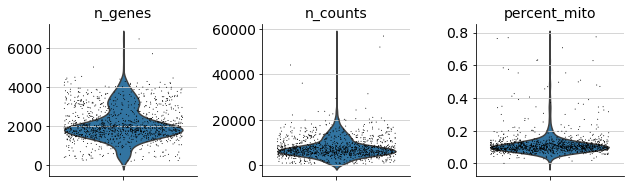

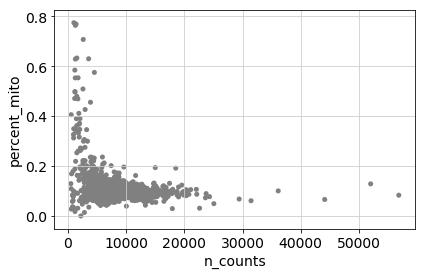

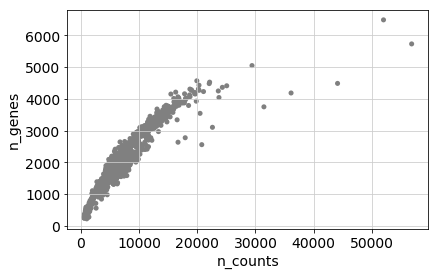

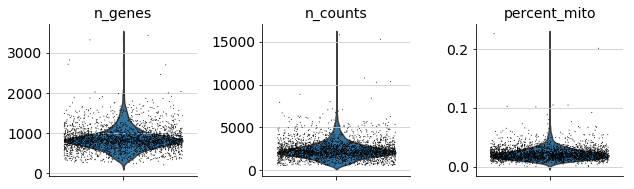

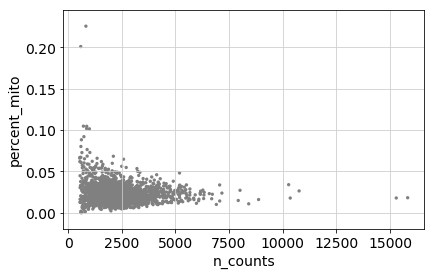

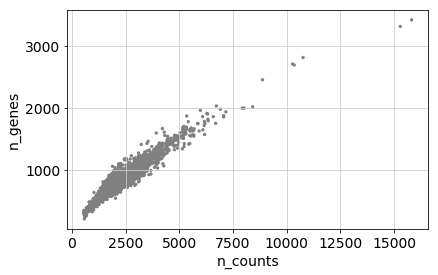

In [6]:
#QC plots
for dataset in datasets:
    sc.pl.violin(dataset, ['n_genes', 'n_counts', 'percent_mito'],jitter=0.4, multi_panel=True)
    sc.pl.scatter(dataset, x='n_counts', y='percent_mito')
    sc.pl.scatter(dataset, x='n_counts', y='n_genes')


2.3) Some more stringent filtering

In [7]:
for dataset in datasets:
    #Filtering those cells in the matrix that have less than 500 genes
    dataset = dataset[dataset.obs['n_genes'] < 500, :]
    #Filtering those cells in the matrix that have less than a 5% of mitochondrial genes 
    dataset= dataset[dataset.obs['percent_mito'] < 0.05, :]

2.4) Normalization and log-transforming 

In [8]:
for dataset in datasets:
    #normalization
    sc.pp.normalize_per_cell(dataset, counts_per_cell_after= 10e4, key_n_counts= 'n_counts')
    #log-transform
    sc.pp.log1p(dataset)

2.5) Optional: Identify highly variable genes. The thresholds were selected to aim for ~10% of all genes as highly variable, but may vary depending on the datasets.

for dataset in datasets: 
    #HVG
    filter_result = sc.pp.filter_genes_dispersion(dataset.X, min_mean=0.0125, max_mean=0.02, min_disp=0.7)
    #plot HVG
    sc.pl.filter_genes_dispersion(filter_result)
    #check HVG
    print( sum([i[0] for i in filter_result]),"HVGs out of:", len(filter_result), "genes")
    
    dataset = dataset[:, filter_result.gene_subset]
    

In [9]:
#merge object
merged = A_data.concatenate(B_data, C_data, join="inner", batch_key = 'batch')

Use intersection (``'inner'``) or union (``'outer'``) of variables.
batch_key denotes the batch identity of each cell. Default is 'batch' but you may name it as desired.

2.6) Visualization

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
    finished (0:00:12.53) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing UMAP


... storing 'feature_types-0' as categorical
... storing 'genome-0' as categorical


    finished (0:00:13.22) --> added
    'X_umap', UMAP coordinates (adata.obsm)


... storing 'feature_types-1' as categorical
... storing 'genome-1' as categorical


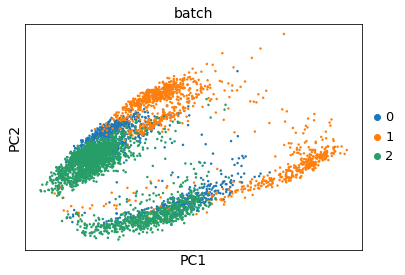

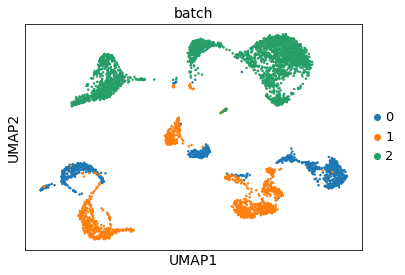

In [10]:
#visualize uncorrected merged object
sc.pp.neighbors(merged,n_pcs=10, n_neighbors=20)
sc.tl.pca(merged)
sc.tl.umap(merged)

sc.pl.pca(merged, color=['batch'])
sc.pl.umap(merged, color=['batch'])

### 3) BBKNN

In [11]:
import bbknn
merged_bbknn = bbknn.bbknn(merged, neighbors_within_batch=5, n_pcs=10, save_knn=True, copy=True)

computing batch balanced neighbors
    finished (0:00:03.82) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix


Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing UMAP
    finished (0:00:09.56) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.27) --> found 12 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


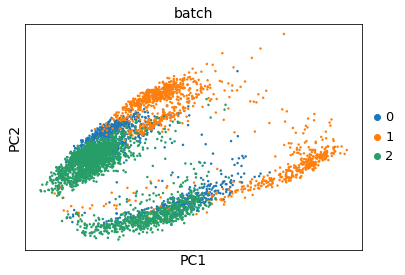

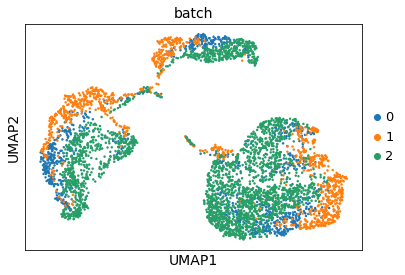

In [12]:
#Visualize correction.
sc.tl.pca(merged_bbknn)
sc.tl.umap(merged_bbknn)
sc.tl.louvain(merged_bbknn)

sc.pl.pca(merged_bbknn, color=['batch'])
sc.pl.umap(merged_bbknn, color=['batch'])

### 4) Scanorama
Scanorama requires loading the individual objects to be merged and corrected. If outputs corrected expression cell x gene matrices.

In [13]:
A_data = merged[merged.obs['batch'] == '0']
B_data = merged[merged.obs['batch'] == '1']
C_data = merged[merged.obs['batch'] == '2']
datasets = [A_data,B_data,C_data]

In [ ]:
#Scanorama
corrected = scanorama.correct_scanpy(datasets)

Found 10894 genes among all datasets
[[0.         0.78486395 0.55376884]
 [0.         0.         0.25680272]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (0, 2)


In [31]:
#merge Scanorama corrected object
merged = corrected[0].concatenate(corrected[1:], join="inner", batch_key = 'batch')

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
    finished (0:00:05.88) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing UMAP


... storing 'feature_types-0-0' as categorical
... storing 'genome-0-0' as categorical
... storing 'feature_types-1-0' as categorical
... storing 'genome-1-0' as categorical


    finished (0:00:12.83) --> added
    'X_umap', UMAP coordinates (adata.obsm)


... storing 'feature_types-0-1' as categorical
... storing 'genome-0-1' as categorical
... storing 'feature_types-1-1' as categorical
... storing 'genome-1-1' as categorical
... storing 'feature_types-0-2' as categorical
... storing 'genome-0-2' as categorical
... storing 'feature_types-1-2' as categorical
... storing 'genome-1-2' as categorical


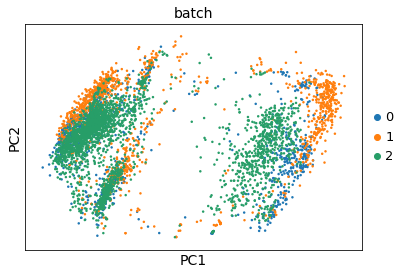

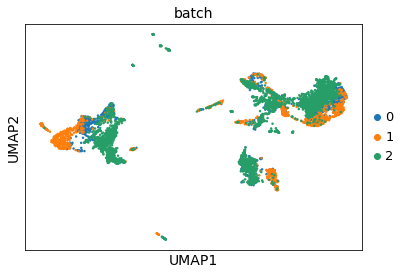

In [32]:
#visualize Scanorama corrected object
sc.pp.neighbors(merged,n_pcs=10, n_neighbors=20)
sc.tl.pca(merged)
sc.tl.umap(merged)

sc.pl.pca(merged, color=['batch'])
sc.pl.umap(merged, color=['batch'])